<a href="https://colab.research.google.com/github/markmets/muusika-minu-elus/blob/main/Tekstikas_20250302_DHNB_GPT_m%C3%A4rgendamine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AUTOMATIC LABELLING WITH OPENAI

#Preparation

In [ ]:
#LAE TEEGID
!pip install openai tiktoken

#põhiteegid
import pandas as pd
import numpy as np

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import Optional,List

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer


#visualiseerimine
import plotly.io as pio  # Import the pio module
pio.templates.default = 'plotly_white'

import tiktoken
from tqdm import tqdm  # Import tqdm for the progress bar

#API VÕTI (Klaus haldab)
# Oma API konto olemasolul leiab võtme: https://platform.openai.com/api-keys
key = "ENTER API KEY"

client = OpenAI(api_key=key)

#sea ridade arv ja tulba laius
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_rows', 40)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.1 MB/s eta 0:00:00


In [ ]:

# Define the raw URL for the Excel file
url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/Laused_t%C3%B5lkega_408.xlsx'
sentences = pd.read_excel(url)

# Apply the renaming to all three DataFrames
sentences.rename(columns={"Lause": "Sentence"}, inplace=True)

# Display the first few rows of the DataFrame
sentences.head()


,Sentence,Translations
0,"""Mullu mina muidu karjas käisin, mullu mina karjas käisin.. ""ja kooli ajal j...","""Last year I was herding, last year I was herding..."" and during school time..."
1,"""Untsakate "", ""Vennaskonna ""J. M. K. E laule, vahel ikka enda laule ka, et o...","Songs by ""Untsakad"", ""Vennaskond"", J.M.K.E., and sometimes my own songs too,..."
2,"1990 kohtasin oma tulevast abikaasat, kes õppis näitlejaks ja võlus mind oma...","In 1990, I met my future spouse, who was studying to become an actor and cha..."
3,20 aasta hiljem on ta ise Viljandi folgil iga-aastane esineja.,"20 years later, they are now an annual performer at the Viljandi Folk Festival."
4,4. klassis sain NSV Liidu hümni laulmise eest hinde 5.,"In 4th grade, I received a grade of 5 for singing the USSR anthem."


#Defineeri funktsioonid

In [ ]:
systemprompt=''
userprompt=''
class myStructure(BaseModel):
    brand: str

def annotate_structured(text,systemprompt=systemprompt,userprompt=userprompt,model="gpt-4o-mini",max_tokens=100):
    response = client.beta.chat.completions.parse(
    model=model,
    temperature=0,
    max_tokens=max_tokens,
    messages=[
        {"role": "system", "content": systemprompt},
        {"role": "user", "content": userprompt+text}
    ],
    response_format=myStructure,
    )
    return response.choices[0].message.parsed, response.usage.prompt_tokens, response.usage.completion_tokens, response,

def annotate_multiple_structured(texts,systemprompt=systemprompt,userprompt=userprompt,model="gpt-4o-mini",max_tokens=10):
    results = []  # Initialize a list to store the results
    # Iterate over each prompt and sentence, applying the GPT model to each
    for idx,text in tqdm(enumerate(texts), total=len(texts), desc="Annotating texts"):
        outputContent, tokens_prompt, tokens_completion, outputFull = annotate_structured(text, systemprompt=systemprompt,userprompt=userprompt, max_tokens=max_tokens, model=model)
        results.append({
        "text": text,
        "result": outputContent,
        "tokens_prompt": int(tokens_prompt),
        "tokens_completion": int(tokens_completion),
        "outputFull":outputFull
        })
    return pd.DataFrame(results) # Convert results to a new DataFrame


# Prompt

In [ ]:
#määra struktureeritud prompt
systemprompt= """You are an expert answering questions about sentences"""
userprompt = """
There are 6 questions about the given sentence. Answer them based on the given coding schemes. Questions about music and sound also pertain different noises and silence.
1. First question is about the Theme. You may choose multiple answers.
pill = talks about playing an instrument
laulmine = talks about singing
tants = talks about dancing
stiil = abstractly about some music style
vahendatud = recorded music and its listening, like radios, records and streaming
elav = listening to live music like concerts and festivals (only when listening)
muusik = about a band, artist, musician, choir director, conductor or specific choirs or people
abstraktne = music as something abstract (music, or to make music in general)
vaikus = silence or lack of sounds
ümbruse hääled = sounds from the environment, like river, dogs, noise etc
muud inimhääled = other human sounds like whistlik, yelling and non-singing
välimus = particular way of dressing or looking like
muu = something else pertaining music, including notes and tunes and lyrics

2. Expression of activity with music or sound. You may choose multiple answers.
kuulamine = listening to music
õppimine = learning and practicing music, music teacher
tegemine = making and performing music (excludes learning)
meeldimine = passive liking or loving of music
fännamine = active fandom
levitamine = spreading music and event organization, includes DJ and sound editing
loomine = music creations
ei = none of them

3. Perspective describing who relates to music or sound. You may choose multiple answers.
ise = the author of the text relates to music, e.g. first person
teine = someone else relates to music, like they or them
meie = author together with someone else (e.g did or felt something together)
üksi = if is abstract or stresses doing alone when doing by themself (e.g. i like to sing alone)
üheskoos = abstract and neither us or them
määramata = unclear or undefined and not fitting in the other categories

4. Attitude (emotion) towards music or sound.
positiivne = positive attitude towards music ('oluline' also indicates positive)
negatiivne = negative attitude towards music
neutraalne = neutral, neither positive or negative, not expressing emotions in relation to music
mitmetähenduslik = if sentence includes multiple emotions, positive and negative, or when its really hard to decide

5. Situation of relating to music or sound. You may choose multiple answers on none.
kodu = home and family
püha = party or gathering, holidays, including ritual singing
kontsert = concerts and festivals
koor = choir and singing in choir
laulupidu = choir music event "laulupidu"
kool = any school including university
asutus = establishment that is not school, like work or kindergarden
loodus = in nature
alkohol = drinking alcohol, being drunk

6. Relating music or sound to certain period of life, age or gender. You may choose multiple answers on none.
lapsepõlv = talks about childhood
kooliiga = schoolyears
noorus = talks about time of youth
täisiga = talks about adult age
vanadus = talks about age or aging in general
mees = talks abot man
naine = talks about woman

Sentence:
"""

class myStructure(BaseModel):
    #description: str = Field(description="""Kirjelda lühidalt....""")
    Theme: List[str] = Field(description="""Answer to 1.Theme""")
    Activity: List[str] = Field(description="""Answer to 2.Activity""")
    Perspective: List[str] = Field(description="""Answer to 3.Perspective""")
    Emotion: str = Field(description="""Answer to 4.Emotion as attitude towards music""")
    Situation: Optional[List[str]]= Field(None, description="""Answer to 5.Situation""")
    Age_reference: Optional[List[str]] = Field(None, description="""Answer to 6.Age and gender""")


# MÄRGENDA

In [ ]:
sentencesSample=sentences.head(10)

In [ ]:
#näidislaused
dfResults=annotate_multiple_structured(sentences['Sentence'].tolist(), userprompt=userprompt, model="gpt-4o", max_tokens=300)
dfResults

Annotating texts: 100%|██████████| 408/408 [12:45<00:00,  1.88s/it]


,text,result,tokens_prompt,tokens_completion,outputFull
0,"""Mullu mina muidu karjas käisin, mullu mina karjas käisin.. ""ja kooli ajal j...","Theme=['laulmine', 'abstraktne', 'muu'] Activity=['kuulamine', 'tegemine'] P...",1021,55,ParsedChatCompletion[myStructure](id='chatcmpl-BIariKll3YAxUf0hnYxO2OWPucY4M...
1,"""Untsakate "", ""Vennaskonna ""J. M. K. E laule, vahel ikka enda laule ka, et o...","Theme=['laulmine', 'muusik', 'muu'] Activity=['kuulamine', 'tegemine'] Persp...",986,47,ParsedChatCompletion[myStructure](id='chatcmpl-BIarkx5JxLnm0h51h7HcqLAxseVAn...
2,"1990 kohtasin oma tulevast abikaasat, kes õppis näitlejaks ja võlus mind oma...","Theme=['pill', 'muusik'] Activity=['õppimine', 'meeldimine'] Perspective=['i...",972,45,ParsedChatCompletion[myStructure](id='chatcmpl-BIarln65VNVkj9G1JVbM4j5G1xKNV...
3,20 aasta hiljem on ta ise Viljandi folgil iga-aastane esineja.,"Theme=['muusik', 'elav'] Activity=['tegemine'] Perspective=['ise'] Emotion='...",960,41,ParsedChatCompletion[myStructure](id='chatcmpl-BIarnL5XZqAPBlzcHZH180xvTJiHA...
4,4. klassis sain NSV Liidu hümni laulmise eest hinde 5.,"Theme=['laulmine', 'kool'] Activity=['tegemine'] Perspective=['ise'] Emotion...",960,45,ParsedChatCompletion[myStructure](id='chatcmpl-BIaroYr0C1sLvjfM7JtEKk5sZQriQ...
...,...,...,...,...,...
403,"Või kui maha tuleb esimene lumi, kuulan jõululaule, et viia end talvisesse m...","Theme=['vahendatud', 'laulmine'] Activity=['kuulamine'] Perspective=['ise'] ...",968,40,ParsedChatCompletion[myStructure](id='chatcmpl-BIb3vnCEL89jDXyg4TNUvmDxTNI4F...
404,"Või Telliskivi keskväljaku kunstmuruväljak, kus on esinenud nii NOEP kui tür...","Theme=['elav', 'muusik'] Activity=['kuulamine'] Perspective=['määramata'] Em...",971,41,ParsedChatCompletion[myStructure](id='chatcmpl-BIb3xW78lD7c2TzvLz21tiN5PpHML...
405,Võib olla ainult maailmas tuntumad poplaulud näiteks Elton Johni või Beatles...,"Theme=['vahendatud', 'muusik', 'abstraktne'] Activity=['kuulamine', 'meeldim...",967,51,ParsedChatCompletion[myStructure](id='chatcmpl-BIb3z02sPoPOmE68YheSRucLOPuiB...
406,"Võibolla mitte teleka kaudu, aga kui oled kontsertil, siis sinu ümber on õhu...","Theme=['elav', 'ümbruse hääled'] Activity=['kuulamine'] Perspective=['ise'] ...",969,45,ParsedChatCompletion[myStructure](id='chatcmpl-BIb41LkcFPLryzm76zm8NgRkTk9ys...


In [ ]:
dfResults['result'][1]

myStructure(Theme=['laulmine', 'muusik', 'muu'], Activity=['kuulamine', 'tegemine'], Perspective=['ise'], Emotion='positiivne', Situation=None, Age_reference=None)

In [ ]:
dfResults_cols = pd.DataFrame()
dfResults_cols['Theme'] = dfResults['result'].apply(lambda x: x.Theme)
dfResults_cols['Activity'] = dfResults['result'].apply(lambda x: x.Activity)
dfResults_cols['Perspective'] = dfResults['result'].apply(lambda x: x.Perspective)
dfResults_cols['Emotion'] = dfResults['result'].apply(lambda x: x.Emotion)
dfResults_cols['Situation'] = dfResults['result'].apply(lambda x: x.Situation)
dfResults_cols['Age_reference'] = dfResults['result'].apply(lambda x: x.Age_reference)


In [ ]:
dfInputCopy = sentences.reset_index(drop=True)
dfOutput = pd.concat([dfInputCopy, dfResults_cols], axis=1)
#dfOutput=dfOutput.fillna('')
#dfOutput = dfOutput.replace('None', '')

dfOutput.head(1)

,Sentence,Translations,Theme,Activity,Perspective,Emotion,Situation,Age_reference
0,"""Mullu mina muidu karjas käisin, mullu mina karjas käisin.. ""ja kooli ajal j...","""Last year I was herding, last year I was herding..."" and during school time...","[laulmine, abstraktne, muu]","[kuulamine, tegemine]",[ise],mitmetähenduslik,[kool],[kooliiga]


In [ ]:
#MAKE LISTS IN TO STRINGS for comparability with human annotators
# List of columns in dfOutput that contain list values
list_columns = ["Theme", "Activity", "Perspective", "Situation", "Age_reference"]

# Convert each list in the specified columns to a comma-separated string
for col in list_columns:
    dfOutput[col] = dfOutput[col].apply(lambda x: ", ".join(x) if isinstance(x, list) else x)

# Display the updated dfOutput to verify the change
(dfOutput.head())


,Sentence,Translations,Theme,Activity,Perspective,Emotion,Situation,Age_reference
0,"""Mullu mina muidu karjas käisin, mullu mina karjas käisin.. ""ja kooli ajal j...","""Last year I was herding, last year I was herding..."" and during school time...","laulmine, abstraktne, muu","kuulamine, tegemine",ise,mitmetähenduslik,kool,kooliiga
1,"""Untsakate "", ""Vennaskonna ""J. M. K. E laule, vahel ikka enda laule ka, et o...","Songs by ""Untsakad"", ""Vennaskond"", J.M.K.E., and sometimes my own songs too,...","laulmine, muusik, muu","kuulamine, tegemine",ise,positiivne,None,None
2,"1990 kohtasin oma tulevast abikaasat, kes õppis näitlejaks ja võlus mind oma...","In 1990, I met my future spouse, who was studying to become an actor and cha...","pill, muusik","õppimine, meeldimine","ise, teine",positiivne,None,None
3,20 aasta hiljem on ta ise Viljandi folgil iga-aastane esineja.,"20 years later, they are now an annual performer at the Viljandi Folk Festival.","muusik, elav",tegemine,ise,positiivne,kontsert,None
4,4. klassis sain NSV Liidu hümni laulmise eest hinde 5.,"In 4th grade, I received a grade of 5 for singing the USSR anthem.","laulmine, kool",tegemine,ise,neutraalne,kool,kooliiga


In [ ]:
dfOutput.to_excel('Masinmärgendatud_408_4o.xlsx', index=False)

# Hinda tulemusi

In [ ]:
#dfOutput=pd.read_excel('Masinmärgendatud_408_4o-mini.xlsx')
dfOutput=pd.read_excel('Masinmärgendatud_408_4o.xlsx')

In [ ]:
import pandas as pd

# Define the raw URL for the Excel file
url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/human-evaluations/Inimm%C3%A4rgendused_408_1.xlsx'
annotator1 = pd.read_excel(url)
url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/human-evaluations/Inimm%C3%A4rgendused_408_2.xlsx'
annotator2 = pd.read_excel(url)

url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/human-evaluations/Inimm%C3%A4rgendused_408_3.xlsx'
annotator3 = pd.read_excel(url)

#remove empty columns
annotator1 = annotator1.dropna(axis=1, how='all')#.head(30)
annotator2 = annotator2.dropna(axis=1, how='all')#.head(30)
annotator3 = annotator3.dropna(axis=1, how='all')#.head(30)

# Define a mapping dictionary with translations
rename_dict = {
    "Lause": "Sentence",
    "3. Teema": "Theme",
    "4. Suhe": "Activity",
    "5. Suhestumise perspektiiv": "Perspective",
    "6. Suhtumise emotsioon": "Emotion",
    "8. Olukord": "Situation",
    "9. Seos ea võis sooga": "Age_reference"
}

# Apply the renaming to all three DataFrames
annotator1.rename(columns=rename_dict, inplace=True)
annotator2.rename(columns=rename_dict, inplace=True)
annotator3.rename(columns=rename_dict, inplace=True)

# Display the first few rows of the DataFrame
(annotator1.head(1))


,Sentence,Theme,Activity,Perspective,Emotion,Situation,Age_reference
0,"""Mullu mina muidu karjas käisin, mullu mina karjas käisin.. ""ja kooli ajal j...","laulmine, muusik",tegemine,ise,mitmetähenduslik,kool,"kooliiga, täisiga"


In [ ]:
#annotator1=annotator1.head(10)
#annotator2=annotator2.head(10)
#annotator3=annotator3.head(10)


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, cohen_kappa_score

def convert_value(val):
    if isinstance(val, list):
        # Sort list items for consistency and join them.
        return ', '.join(sorted([str(item).strip().lower() for item in val]))
    elif isinstance(val, str):
        # Split on commas, sort the tokens, and join them back.
        tokens = [token.strip().lower() for token in val.split(",") if token.strip()]
        return ', '.join(sorted(tokens))
    elif pd.isnull(val):
        return ""
    else:
        return str(val).strip().lower()

# List of columns to compare.
cols = ['Theme', 'Activity', 'Perspective', 'Emotion', 'Situation', 'Age_reference']

# Preprocessing function: apply normalization to each cell of the specified columns.
def preprocess(df, columns):
    df_proc = df.copy()
    for col in columns:
        df_proc[col] = df_proc[col].apply(convert_value)
    return df_proc

# Preprocess the DataFrames.
dfOutput_proc   = preprocess(dfOutput, cols)
annotator1_proc = preprocess(annotator1, cols)
annotator2_proc = preprocess(annotator2, cols)
annotator3_proc = preprocess(annotator3, cols)

# Dictionary to access DataFrames by name.
sources = {
    'dfOutput': dfOutput_proc,
    'annotator1': annotator1_proc,
    'annotator2': annotator2_proc,
    'annotator3': annotator3_proc
}

# Define the pairs to compare: only compare dfOutput with each annotator.
pairs = [
    ('dfOutput', 'annotator1'),
    ('dfOutput', 'annotator2'),
    ('dfOutput', 'annotator3')
]

# Prepare a list to store the results per column.
result_list = []

# Loop through each column (e.g., Theme, Activity, etc.)
for col in cols:
    # Dictionary to store metrics for the current column.
    metrics = {}
    kappas = []
    accuracies = []

    for source1, source2 in pairs:
        y1 = sources[source1][col]
        y2 = sources[source2][col]
        kappa = cohen_kappa_score(y1, y2)
        acc = accuracy_score(y1, y2)
        # Key names indicate the pair compared.
        metrics[f'kappa_{source1}_vs_{source2}'] = kappa
        metrics[f'accuracy_{source1}_vs_{source2}'] = acc
        kappas.append(kappa)
        accuracies.append(acc)

    # Compute average kappa and accuracy for the column.
    metrics['avg_kappa'] = sum(kappas) / len(kappas)
    metrics['avg_accuracy'] = sum(accuracies) / len(accuracies)
    metrics['Category'] = col
    result_list.append(metrics)

# Create a DataFrame from the results.
results_df = pd.DataFrame(result_list)

# Compute overall averages across all attributes.
overall = {
    'Category': 'Average',
    'kappa_dfOutput_vs_annotator1': results_df['kappa_dfOutput_vs_annotator1'].mean(),
    'kappa_dfOutput_vs_annotator2': results_df['kappa_dfOutput_vs_annotator2'].mean(),
    'kappa_dfOutput_vs_annotator3': results_df['kappa_dfOutput_vs_annotator3'].mean(),
    'accuracy_dfOutput_vs_annotator1': results_df['accuracy_dfOutput_vs_annotator1'].mean(),
    'accuracy_dfOutput_vs_annotator2': results_df['accuracy_dfOutput_vs_annotator2'].mean(),
    'accuracy_dfOutput_vs_annotator3': results_df['accuracy_dfOutput_vs_annotator3'].mean(),
    'avg_kappa': results_df['avg_kappa'].mean(),
    'avg_accuracy': results_df['avg_accuracy'].mean()
}

# Append the overall averages as a new row.
results_df = pd.concat([results_df, pd.DataFrame([overall])], ignore_index=True)

# Reorder the columns if desired.
ordered_cols = [
    'Category',
    'kappa_dfOutput_vs_annotator1',
    'kappa_dfOutput_vs_annotator2',
    'kappa_dfOutput_vs_annotator3',
    'accuracy_dfOutput_vs_annotator1',
    'accuracy_dfOutput_vs_annotator2',
    'accuracy_dfOutput_vs_annotator3',
    'avg_kappa',
    'avg_accuracy'
]
results_df = results_df[ordered_cols]

# Save the resulting table to an Excel file.
results_df.to_excel("kappa_accuracy_exact_matches.xlsx", index=False)

print("Kappa and accuracy for exact matches:")
(results_df)


Kappa and accuracy for exact matches:


,Category,kappa_dfOutput_vs_annotator1,kappa_dfOutput_vs_annotator2,kappa_dfOutput_vs_annotator3,accuracy_dfOutput_vs_annotator1,accuracy_dfOutput_vs_annotator2,accuracy_dfOutput_vs_annotator3,avg_kappa,avg_accuracy
0,Theme,0.300791,0.278020,0.237002,0.330882,0.303922,0.267157,0.271938,0.300654
1,Activity,0.454864,0.431379,0.434919,0.529412,0.509804,0.517157,0.440387,0.518791
2,Perspective,0.521588,0.540990,0.560742,0.671569,0.664216,0.681373,0.541106,0.672386
3,Emotion,0.462360,0.447309,0.480733,0.654412,0.644608,0.681373,0.463468,0.660131
4,Situation,0.614802,0.559035,0.657491,0.774510,0.727941,0.801471,0.610443,0.767974
5,Age_reference,0.588082,0.471749,0.545826,0.889706,0.789216,0.852941,0.535219,0.843954
6,Average,0.490415,0.454747,0.486119,0.641748,0.606618,0.633578,0.477093,0.627315


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer

def process_dfoutput_value(val):
    """Process a dfOutput value expected to be a list-like object (or None).
       Normalize each string (lowercase, stripped). If None or NaN, return an empty set.
       The returned set ensures that the order of labels does not matter.
    """
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return set()
    if isinstance(val, (list, np.ndarray)):
        return {str(item).strip().lower() for item in val if item is not None and pd.notna(item)}
    # Fallback: treat as a comma-separated string
    return {choice.strip().lower() for choice in str(val).split(",") if choice.strip()}

def process_response(response):
    """Process an annotator's response string (comma-separated) into a set of normalized choices.
       If the response is "NONE", return an empty set.
       Using sets here makes the order irrelevant.
    """
    if response == "NONE":
        return set()
    return {choice.strip().lower() for choice in response.split(",") if choice.strip()}

# Define the multi-label columns to process.
multi_label_columns = ["Theme", "Activity", "Perspective", "Emotion", "Situation", "Age_reference"]

# Dictionary to hold F1 results per category.
f1_results = {}

for col in multi_label_columns:
    # Process dfOutput values (which are expected to be list-like objects or None).
    responses_dfOutput = [process_dfoutput_value(val) for val in dfOutput[col]]

    # Process annotator responses (which are comma-separated strings or "NONE").
    responses_ann1 = [process_response(str(val)) for val in annotator1[col].fillna("NONE")]
    responses_ann2 = [process_response(str(val)) for val in annotator2[col].fillna("NONE")]
    responses_ann3 = [process_response(str(val)) for val in annotator3[col].fillna("NONE")]

    # Combine all responses to determine the full set of labels (order doesn't matter because of sets).
    all_responses = responses_dfOutput + responses_ann1 + responses_ann2 + responses_ann3
    all_labels = set().union(*all_responses)

    # Initialize and fit the MultiLabelBinarizer using the full set of labels.
    mlb = MultiLabelBinarizer(classes=list(all_labels)) if all_labels else MultiLabelBinarizer()
    mlb.fit(all_responses)

    # Transform the responses into binary indicator arrays.
    y_dfOutput = mlb.transform(responses_dfOutput)
    y_ann1 = mlb.transform(responses_ann1)
    y_ann2 = mlb.transform(responses_ann2)
    y_ann3 = mlb.transform(responses_ann3)

    # Compute F1 scores comparing dfOutput with each annotator.
    f1_df_ann1 = f1_score(y_dfOutput, y_ann1, average="weighted", zero_division=1)
    f1_df_ann2 = f1_score(y_dfOutput, y_ann2, average="weighted", zero_division=1)
    f1_df_ann3 = f1_score(y_dfOutput, y_ann3, average="weighted", zero_division=1)

    # Calculate average F1 for the current column.
    avg_f1 = (f1_df_ann1 + f1_df_ann2 + f1_df_ann3) / 3

    # Store results for this column with the category label.
    f1_results[col] = {
        'Category': col,
        'f1_dfOutput_vs_annotator1': f1_df_ann1,
        'f1_dfOutput_vs_annotator2': f1_df_ann2,
        'f1_dfOutput_vs_annotator3': f1_df_ann3,
        'avg_f1': avg_f1
    }

# Convert results to a DataFrame.
results_df = pd.DataFrame(list(f1_results.values()))

# Compute overall average scores across all categories.
overall = {
    'Category': 'Average',
    'f1_dfOutput_vs_annotator1': results_df['f1_dfOutput_vs_annotator1'].mean(),
    'f1_dfOutput_vs_annotator2': results_df['f1_dfOutput_vs_annotator2'].mean(),
    'f1_dfOutput_vs_annotator3': results_df['f1_dfOutput_vs_annotator3'].mean(),
    'avg_f1': results_df['avg_f1'].mean()
}

# Append the overall averages as a new row.
results_df = pd.concat([results_df, pd.DataFrame([overall])], ignore_index=True)

# Order the columns as desired.
ordered_cols = [
    'Category',
    'f1_dfOutput_vs_annotator1',
    'f1_dfOutput_vs_annotator2',
    'f1_dfOutput_vs_annotator3',
    'avg_f1'
]
results_df = results_df[ordered_cols]

# Save the final F1 results table to an Excel file.
results_df.to_excel("multi_label_f1_scores.xlsx", index=False)

print("Multi-label F1 Score Results Table:")
(results_df)


Multi-label F1 Score Results Table:


,Category,f1_dfOutput_vs_annotator1,f1_dfOutput_vs_annotator2,f1_dfOutput_vs_annotator3,avg_f1
0,Theme,0.618818,0.591971,0.553666,0.588152
1,Activity,0.676936,0.657733,0.649326,0.661332
2,Perspective,0.746156,0.751601,0.755830,0.751195
3,Emotion,0.656441,0.656520,0.688805,0.667255
4,Situation,0.728016,0.673793,0.736513,0.712774
5,Age_reference,0.584184,0.558580,0.568305,0.570356
6,Average,0.668425,0.648366,0.658741,0.658511


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

def process_response(response):
    """Convert a response string into a set of normalized choices.
       If the response is "NONE", return an empty set.
    """
    if response == "NONE":
        return set()
    return {choice.strip().lower() for choice in response.split(",") if choice.strip()}

# Define the multi-label columns to process
multi_label_columns = ["Theme", "Activity", "Perspective", "Emotion", "Situation", "Age_reference"]

# Define the annotator pairs to compare
annotator_pairs = [
    ("annotator1", annotator1, "annotator2", annotator2),
    ("annotator1", annotator1, "annotator3", annotator3),
    ("annotator2", annotator2, "annotator3", annotator3)
]

# Mapping of annotator names to short names (for naming the Excel sheets)
short_names = {
    "annotator1": "ann1",
    "annotator2": "ann2",
    "annotator3": "ann3"
}

# Dictionary to store classification report DataFrames for each comparison
reports_dfs = {}

for col in multi_label_columns:
    for name1, df1, name2, df2 in annotator_pairs:
        # Process responses for each annotator for the current column
        responses1 = [process_response(str(x)) for x in df1[col].fillna("NONE")]
        responses2 = [process_response(str(x)) for x in df2[col].fillna("NONE")]

        # Combine responses from both annotators to get the full set of labels
        all_responses = responses1 + responses2

        # Initialize and fit the MultiLabelBinarizer on the union of labels
        mlb = MultiLabelBinarizer()
        mlb.fit(all_responses)

        # Transform both sets of responses into binary indicator matrices
        y_true = mlb.transform(responses1)
        y_pred = mlb.transform(responses2)

        # Generate the classification report as a dictionary
        report_dict = classification_report(
            y_true,
            y_pred,
            target_names=mlb.classes_,
            zero_division=0,
            output_dict=True
        )

        # Convert the report dictionary to a DataFrame and transpose for clarity
        report_df = pd.DataFrame(report_dict).transpose()

        # Create a unique key for this report using the column and annotator short names
        sheet_key = f"{col}_{short_names[name1]}_vs_{short_names[name2]}"
        reports_dfs[sheet_key] = report_df

# Save all the classification reports into one Excel file with one sheet per report
with pd.ExcelWriter("classification_reports.xlsx") as writer:
    for sheet_name, df_report in reports_dfs.items():
        df_report.to_excel(writer, sheet_name=sheet_name)

print("Classification reports have been saved to 'classification_reports.xlsx'.")


Classification reports have been saved to 'classification_reports.xlsx'.


Mismatches saved to Valedmärgendused.xlsx


# Mistakes

In [ ]:
import pandas as pd

# List of columns to compare.
multi_label_columns = ["Theme", "Activity", "Perspective", "Emotion", "Situation", "Age_reference"]

# Define columns to merge: "Sentence" plus all multi-label columns.
cols = ["Sentence"] + multi_label_columns

# Merge the two DataFrames on 'Sentence' using the selected columns.
df_merged = pd.merge(dfOutput[cols],
                     annotator2[cols],
                     on="Sentence",
                     suffixes=('_Machine', '_Human'))

# Rename the merged columns for clarity.
rename_map = {}
for col in multi_label_columns:
    rename_map[f"{col}_Machine"] = f"Masin_{col}"
    rename_map[f"{col}_Human"] = f"Inim_{col}"
df_merged.rename(columns=rename_map, inplace=True)

def process_value(val):
    """
    Convert a value to a set of stripped elements.
    - If val is a list, tuple, or set, convert each element to a string and strip it.
    - If it's a string, split on commas and strip each element.
    - If val is NaN or empty, return an empty set.
    """
    if pd.isna(val):
        return set()
    if isinstance(val, (list, tuple, set)):
        return {str(item).strip() for item in val if str(item).strip()}
    if isinstance(val, str):
        val = val.strip()
        if val == "":
            return set()
        return {item.strip() for item in val.split(",") if item.strip()}
    # For any other type, convert to string.
    s = str(val).strip()
    return {s} if s else set()

output_file = "Valedmärgendused.xlsx"
with pd.ExcelWriter(output_file) as writer:
    for col in multi_label_columns:
        machine_col = f"Masin_{col}"
        human_col = f"Inim_{col}"

        # Create a mask for rows where:
        # 1. The processed sets are different.
        # 2. At least one of the processed sets is non-empty.
        mask = df_merged.apply(
            lambda row: (process_value(row[machine_col]) != process_value(row[human_col])) and
                        bool(process_value(row[machine_col]) or process_value(row[human_col])),
            axis=1
        )
        df_mismatch = df_merged.loc[mask, ["Sentence", machine_col, human_col]]

        # Write the mismatches for the current column to its own sheet.
        df_mismatch.to_excel(writer, sheet_name=col, index=False)

print(f"Mismatches saved to {output_file}")


#Comparison to human baseline

In [ ]:
# Define the raw URL for the Excel file
url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/evaluations/humans_kappa_accuracy_exact_matches.xlsx'
humanskappa = pd.read_excel(url)
url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/evaluations/humans_multi_label_f1_scores%20.xlsx'
humansf1 = pd.read_excel(url)

url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/evaluations/AI_4o_kappa_accuracy_exact_matches.xlsx'
AIkappa = pd.read_excel(url)
url = 'https://raw.githubusercontent.com/markmets/muusika-minu-elus/main/evaluations/AI_4o_multi_label_f1_scores.xlsx'
AIf1 = pd.read_excel(url)


In [ ]:
humanskappa

,Category,kappa_annotator1_vs_annotator2,kappa_annotator1_vs_annotator3,kappa_annotator2_vs_annotator3,accuracy_annotator1_vs_annotator2,accuracy_annotator1_vs_annotator3,accuracy_annotator2_vs_annotator3,avg_kappa,avg_accuracy
0,Theme,0.464023,0.498961,0.458660,0.512255,0.553922,0.509804,0.473881,0.525327
1,Activity,0.583656,0.604144,0.596551,0.651961,0.674020,0.669118,0.594784,0.665033
2,Perspective,0.512166,0.530800,0.554428,0.664216,0.678922,0.674020,0.532465,0.672386
3,Emotion,0.437548,0.462575,0.519698,0.615196,0.651961,0.683824,0.473274,0.650327
4,Situation,0.663161,0.700731,0.708840,0.774510,0.808824,0.806373,0.690911,0.796569
5,Age_reference,0.404737,0.570907,0.553899,0.779412,0.875000,0.813725,0.509848,0.822712
6,Average,0.510882,0.561353,0.565346,0.666258,0.707108,0.692810,0.545860,0.688725


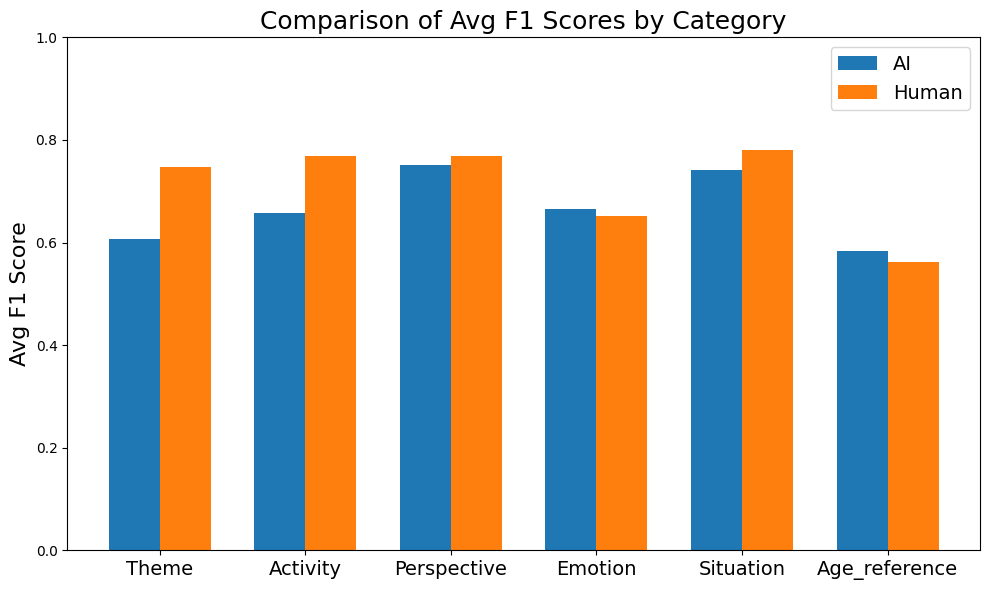

<ipython-input-135-7df366d6334d>:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(merged_df['Category'], fontsize=14)


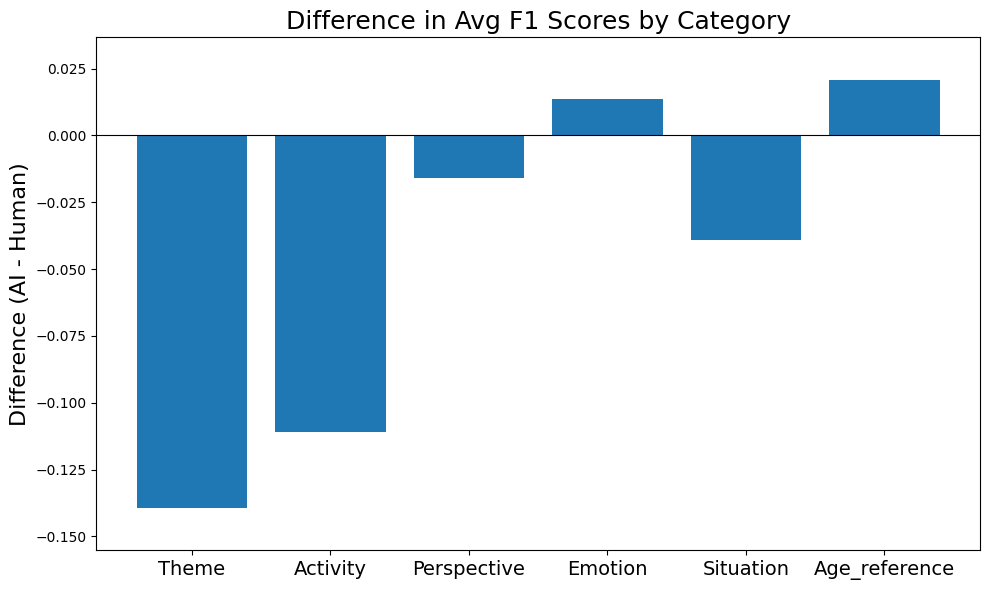

In [ ]:
import matplotlib.pyplot as plt

# Merge your dataframes on 'Category'
merged_df = AIf1[['Category', 'avg_f1']].merge(
    humansf1[['Category', 'avg_f1']], on='Category', suffixes=('_AI', '_Human')
)

# Option 1: Grouped Bar Chart
x = range(len(merged_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([p - width/2 for p in x], merged_df['avg_f1_AI'], width, label='AI')
ax.bar([p + width/2 for p in x], merged_df['avg_f1_Human'], width, label='Human')
ax.set_xticks(x)
ax.set_xticklabels(merged_df['Category'], fontsize=14)
ax.set_ylim(0, 1)
ax.set_ylabel('Avg F1 Score', fontsize=16)
ax.set_title('Comparison of Avg F1 Scores by Category', fontsize=18)
ax.legend(fontsize=14)
plt.tight_layout()
plt.savefig('grouped_bar_chart.png', dpi=400)
plt.show()

# Option 2: Difference Bar Plot
merged_df['Difference'] = merged_df['avg_f1_AI'] - merged_df['avg_f1_Human']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(merged_df['Category'], merged_df['Difference'])

# Calculate dynamic y-axis limits with a 10% margin
diff_min = merged_df['Difference'].min()
diff_max = merged_df['Difference'].max()
margin = (diff_max - diff_min) * 0.1 if diff_max != diff_min else 0.1
ax.set_ylim(diff_min - margin, diff_max + margin)

ax.axhline(0, color='black', linewidth=0.8)  # Reference line at 0
ax.set_ylabel('Difference (AI - Human)', fontsize=16)
ax.set_title('Difference in Avg F1 Scores by Category', fontsize=18)
ax.set_xticklabels(merged_df['Category'], fontsize=14)
plt.tight_layout()
plt.savefig('difference_bar_plot.png', dpi=400)
plt.show()


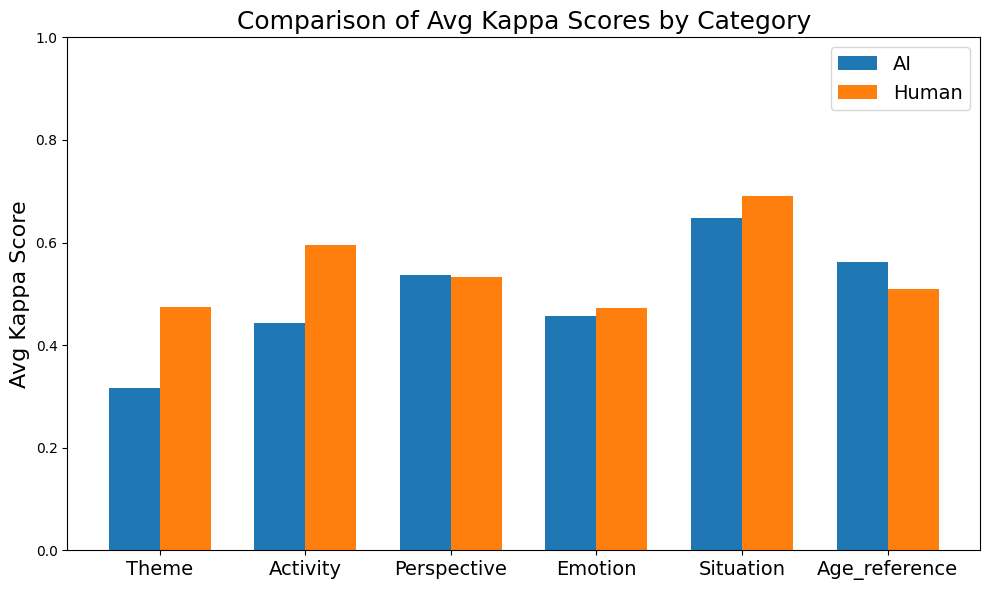

<ipython-input-141-52ad7958a311>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(merged_df_kappa['Category'], fontsize=14)


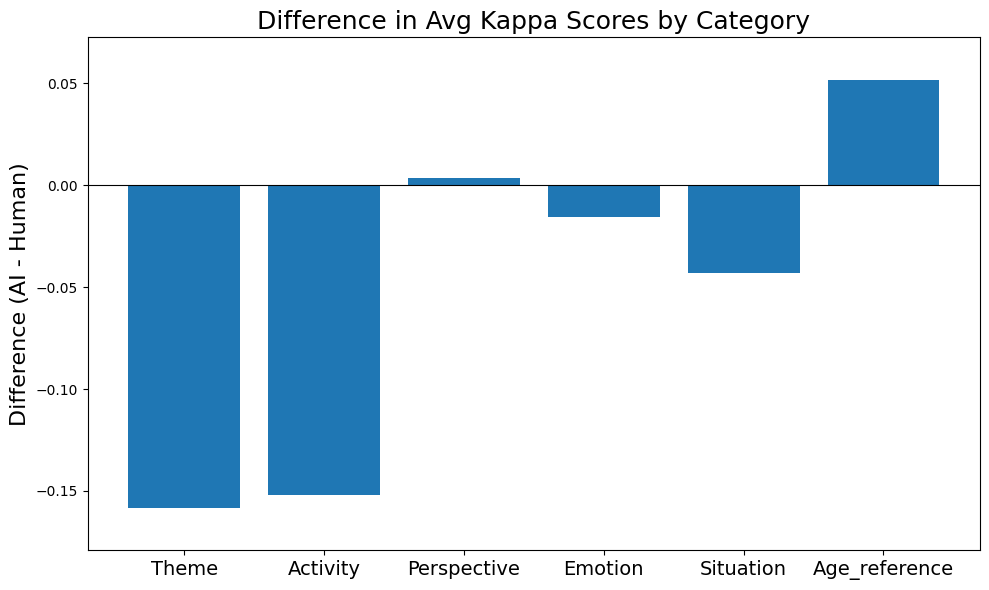

In [ ]:
import matplotlib.pyplot as plt

# Exclude the 'Average' category from both dataframes
AIkappa_filtered = AIkappa[AIkappa['Category'] != 'Average']
humanskapp_filtered = humanskappa[humanskappa['Category'] != 'Average']

# Merge the filtered dataframes on 'Category'
merged_df_kappa = AIkappa_filtered[['Category', 'avg_kappa']].merge(
    humanskapp_filtered[['Category', 'avg_kappa']], on='Category', suffixes=('_AI', '_Human')
)

# Option 1: Grouped Bar Chart for avg_kappa
x = range(len(merged_df_kappa))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([p - width/2 for p in x], merged_df_kappa['avg_kappa_AI'], width, label='AI')
ax.bar([p + width/2 for p in x], merged_df_kappa['avg_kappa_Human'], width, label='Human')
ax.set_xticks(x)
ax.set_xticklabels(merged_df_kappa['Category'], fontsize=14)
ax.set_ylim(0, 1)
ax.set_ylabel('Avg Kappa Score', fontsize=16)
ax.set_title('Comparison of Avg Kappa Scores by Category', fontsize=18)
ax.legend(fontsize=14)
plt.tight_layout()
plt.savefig('grouped_bar_chart_kappa.png', dpi=400)
plt.show()

# Option 2: Difference Bar Plot for avg_kappa
merged_df_kappa['Difference'] = merged_df_kappa['avg_kappa_AI'] - merged_df_kappa['avg_kappa_Human']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(merged_df_kappa['Category'], merged_df_kappa['Difference'])
ax.axhline(0, color='black', linewidth=0.8)  # Reference line at 0

# Dynamically calculate y-axis limits with a margin
diff_min = merged_df_kappa['Difference'].min()
diff_max = merged_df_kappa['Difference'].max()
margin = (diff_max - diff_min) * 0.1 if diff_max != diff_min else 0.1
ax.set_ylim(diff_min - margin, diff_max + margin)

ax.set_ylabel('Difference (AI - Human)', fontsize=16)
ax.set_title('Difference in Avg Kappa Scores by Category', fontsize=18)
ax.set_xticklabels(merged_df_kappa['Category'], fontsize=14)
plt.tight_layout()
plt.savefig('difference_bar_plot_kappa.png', dpi=400)
plt.show()
